# PM2.5 Enriched Dataset - Exploratory Data Analysis

Analysis of the enriched PM2.5 dataset with traffic and weather features for model development.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Data Overview

In [2]:
df = pd.read_csv('../data/pm25_enriched_hourly.csv', parse_dates=['timestamp'])
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

Dataset shape: 9,457,112 rows × 17 columns
Memory usage: 4.03 GB


In [3]:
df.dtypes

hex7_id                               object
timestamp                datetime64[ns, UTC]
pm25_ugm3_mean                       float64
lat                                  float64
lon                                  float64
nearest_traffic_hex                   object
traffic_distance_km                  float64
has_local_traffic                       bool
nearest_weather_hex                   object
weather_distance_km                  float64
has_local_weather                       bool
avg_traffic_volume                   float64
traffic_source                        object
temperature_c_mean                   float64
humidity_pct_mean                    float64
precipitation_mm_mean                float64
weather_source                        object
dtype: object

### Temporal Coverage

In [4]:
print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")
print(f"Unique timestamps: {df['timestamp'].nunique():,}")
print(f"Unique hexagons: {df['hex7_id'].nunique():,}")
print(f"Average records per hexagon: {len(df) / df['hex7_id'].nunique():.0f}")

Time range: 2023-07-14 16:00:00+00:00 to 2025-07-26 05:00:00+00:00
Duration: 742 days
Unique timestamps: 16,004
Unique hexagons: 634
Average records per hexagon: 14917


In [5]:
time_diff = df.groupby('hex7_id')['timestamp'].apply(lambda x: x.sort_values().diff().dt.total_seconds() / 3600)
print(f"Sampling frequency (hours between measurements):")
print(time_diff.dropna().value_counts().head(10))

Sampling frequency (hours between measurements):
timestamp
1.00      8995710
3.00       430528
2.00        21292
4.00         3318
171.00        628
137.00        625
19.00         579
41.00         578
5.00          404
57.00         246
Name: count, dtype: int64


### Missing Values Analysis

In [6]:
missing_stats = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['Missing Count'] > 0].sort_values('Missing %', ascending=False)
missing_stats

,Missing Count,Missing %
temperature_c_mean,8482770,89.70
humidity_pct_mean,8482770,89.70
precipitation_mm_mean,8482089,89.69
avg_traffic_volume,7455278,78.83
pm25_ugm3_mean,1839574,19.45
nearest_traffic_hex,2087,0.02
traffic_source,2087,0.02


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Missing values over time for key features
missing_by_time_pm25 = df.groupby(df['timestamp'].dt.date)['pm25_ugm3_mean'].apply(lambda x: x.isnull().mean() * 100)
missing_by_time_traffic = df.groupby(df['timestamp'].dt.date)['avg_traffic_volume'].apply(lambda x: x.isnull().mean() * 100)
missing_by_time_weather = df.groupby(df['timestamp'].dt.date)['temperature_c_mean'].apply(lambda x: x.isnull().mean() * 100)

axes[0, 0].plot(missing_by_time_pm25.index, missing_by_time_pm25.values, label='PM2.5', linewidth=2)
axes[0, 0].plot(missing_by_time_traffic.index, missing_by_time_traffic.values, label='Traffic', linewidth=2, alpha=0.7)
axes[0, 0].plot(missing_by_time_weather.index, missing_by_time_weather.values, label='Weather', linewidth=2, alpha=0.7)
axes[0, 0].set_title('Missing Values Over Time for Key Features')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Missing %')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Distribution of missing PM2.5 by hexagon
missing_by_hex = df.groupby('hex7_id')['pm25_ugm3_mean'].apply(lambda x: x.isnull().mean() * 100)
axes[0, 1].hist(missing_by_hex, bins=50, edgecolor='black', color='steelblue')
axes[0, 1].set_title('Distribution of Missing PM2.5 by Hexagon')
axes[0, 1].set_xlabel('Missing %')
axes[0, 1].set_ylabel('Number of Hexagons')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Missing data heatmap by feature
all_cols = [col for col in df.columns if col not in ['hex7_id', 'timestamp', 'nearest_traffic_hex', 'nearest_weather_hex']]
missing_by_feature = df[all_cols].isnull().mean() * 100
missing_by_feature = missing_by_feature.sort_values(ascending=False)

colors = ['red' if x > 50 else 'orange' if x > 20 else 'green' for x in missing_by_feature.values]
bars = axes[1, 0].barh(range(len(missing_by_feature)), missing_by_feature.values, color=colors, edgecolor='black')
axes[1, 0].set_yticks(range(len(missing_by_feature)))
axes[1, 0].set_yticklabels(missing_by_feature.index, fontsize=9)
axes[1, 0].set_xlabel('Missing %')
axes[1, 0].set_title('Missing Data Percentage by Feature')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, missing_by_feature.values)):
    axes[1, 0].text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
                    va='center', fontsize=8)

# Plot 4: Correlation of missingness between features
# Create binary missing indicators for key features
missing_indicators = pd.DataFrame({
    'PM2.5': df['pm25_ugm3_mean'].isnull().astype(int),
    'Traffic': df['avg_traffic_volume'].isnull().astype(int),
    'Temperature': df['temperature_c_mean'].isnull().astype(int),
    'Humidity': df['humidity_pct_mean'].isnull().astype(int),
    'Precipitation': df['precipitation_mm_mean'].isnull().astype(int)
})

# Calculate correlation matrix
missing_corr = missing_indicators.corr()

# Plot heatmap
im = axes[1, 1].imshow(missing_corr, cmap='RdYlBu_r', aspect='auto', vmin=-1, vmax=1)
axes[1, 1].set_xticks(range(len(missing_corr.columns)))
axes[1, 1].set_yticks(range(len(missing_corr.columns)))
axes[1, 1].set_xticklabels(missing_corr.columns, rotation=45, ha='right')
axes[1, 1].set_yticklabels(missing_corr.columns)
axes[1, 1].set_title('Correlation of Missing Data Patterns')

# Add correlation values
for i in range(len(missing_corr.columns)):
    for j in range(len(missing_corr.columns)):
        text = axes[1, 1].text(j, i, f'{missing_corr.iloc[i, j]:.2f}',
                               ha='center', va='center', color='black' if abs(missing_corr.iloc[i, j]) < 0.5 else 'white',
                               fontsize=9)

# Add colorbar
plt.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.suptitle('Comprehensive Missing Data Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nMissing Data Summary:")
print("-" * 50)
print(f"Features with >50% missing: {sum(missing_by_feature > 50)}")
print(f"Features with 20-50% missing: {sum((missing_by_feature >= 20) & (missing_by_feature <= 50))}")
print(f"Features with <20% missing: {sum(missing_by_feature < 20)}")
print(f"\nMost complete features: {missing_by_feature.tail(3).index.tolist()}")
print(f"Least complete features: {missing_by_feature.head(3).index.tolist()}")

### Basic Statistics

In [8]:
numerical_cols = ['pm25_ugm3_mean', 'traffic_distance_km', 'weather_distance_km', 
                 'avg_traffic_volume', 'temperature_c_mean', 'humidity_pct_mean', 'precipitation_mm_mean']

df_clean = df[numerical_cols].replace([np.inf, -np.inf], np.nan)
df_clean.describe()

,pm25_ugm3_mean,traffic_distance_km,weather_distance_km,avg_traffic_volume,temperature_c_mean,humidity_pct_mean,precipitation_mm_mean
count,7617538.00,9455025.00,9457112.00,2001834.00,974342.00,974342.00,975023.00
mean,9.00,5.92,22.11,34.61,18.52,77.00,0.16
std,7.99,14.39,15.35,23.58,10.12,14.44,0.76
min,0.00,0.00,0.00,0.00,-20.90,15.00,0.00
25%,5.00,3.10,9.77,11.50,9.90,67.00,0.00
50%,8.00,4.25,18.60,35.27,21.10,79.00,0.00
75%,12.00,5.55,32.36,52.27,27.20,89.00,0.00
max,4170.00,406.76,69.06,264.00,38.30,100.00,30.40


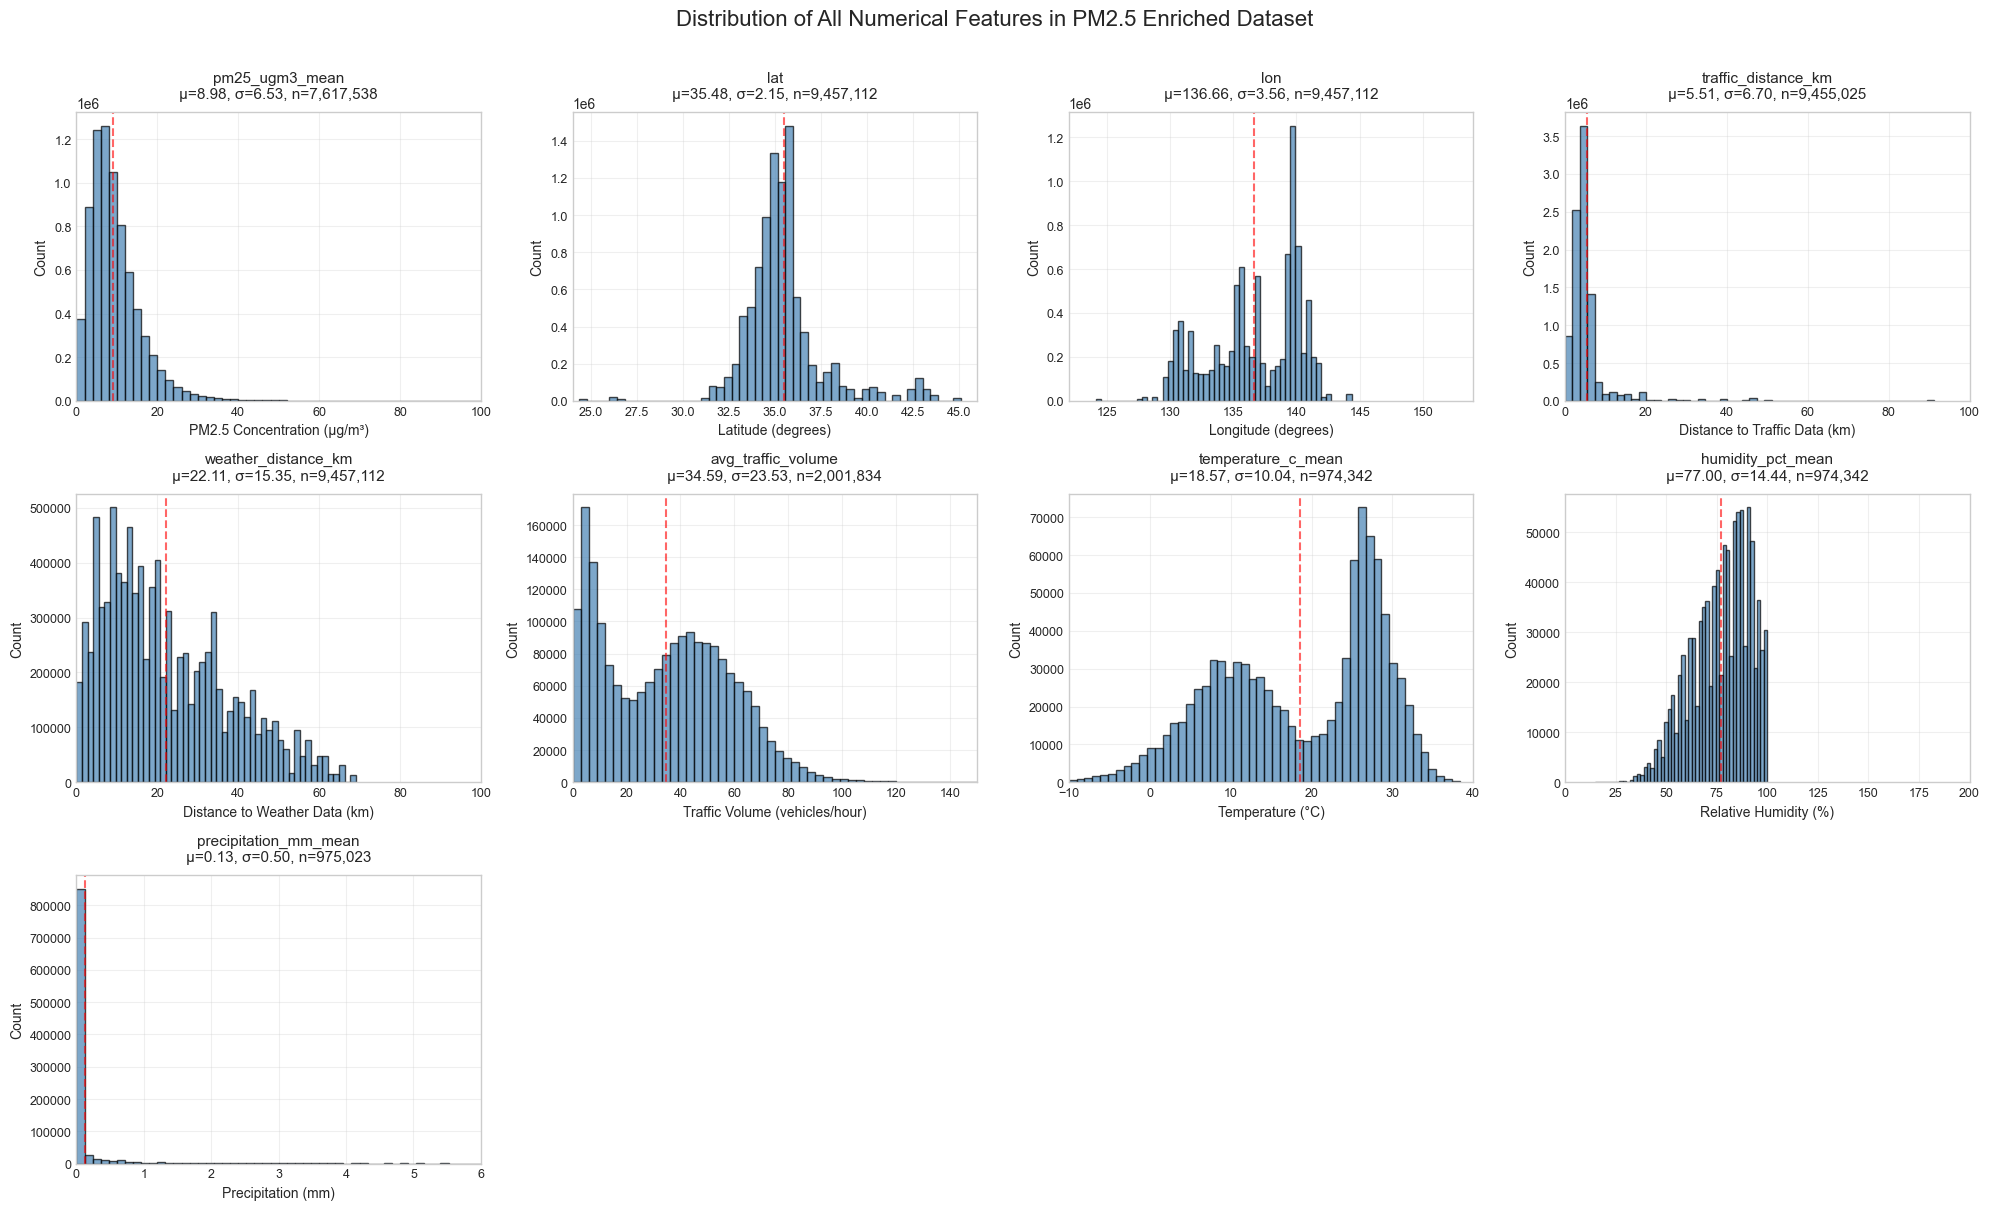


Total numerical features plotted: 9
Features: pm25_ugm3_mean, lat, lon, traffic_distance_km, weather_distance_km, avg_traffic_volume, temperature_c_mean, humidity_pct_mean, precipitation_mm_mean


In [9]:
# Get all numerical features for comprehensive plotting
all_cols = [col for col in df.columns if col not in ['hex7_id', 'timestamp', 'nearest_traffic_hex', 'nearest_weather_hex']]
numerical_features = df[all_cols].select_dtypes(include=[np.number]).columns.tolist()

# Plot all numerical features in one figure
n_cols = 4
n_rows = (len(numerical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

# Define x-axis limits and labels
x_limits = {
    'pm25_ugm3_mean': (0, 100),
    'traffic_distance_km': (0, 100),
    'weather_distance_km': (0, 100),
    'avg_traffic_volume': (0, 150),
    'temperature_c_mean': (-10, 40),
    'humidity_pct_mean': (0, 200),
    'precipitation_mm_mean': (0, 6),
    'lat': (24, 46),
    'lon': (122, 154)
}

# Define proper axis labels with units
axis_labels = {
    'pm25_ugm3_mean': 'PM2.5 Concentration (μg/m³)',
    'traffic_distance_km': 'Distance to Traffic Data (km)',
    'weather_distance_km': 'Distance to Weather Data (km)',
    'avg_traffic_volume': 'Traffic Volume (vehicles/hour)',
    'temperature_c_mean': 'Temperature (°C)',
    'humidity_pct_mean': 'Relative Humidity (%)',
    'precipitation_mm_mean': 'Precipitation (mm)',
    'lat': 'Latitude (degrees)',
    'lon': 'Longitude (degrees)',
    'has_local_traffic': 'Has Local Traffic Data',
    'has_local_weather': 'Has Local Weather Data'
}

for i, col in enumerate(numerical_features):
    data = df[col].dropna()
    data = data[np.isfinite(data)]
    
    if len(data) > 0:
        # Apply x-axis limits if defined, otherwise use percentile-based limits
        if col in x_limits:
            data_filtered = data[(data >= x_limits[col][0]) & (data <= x_limits[col][1])]
        else:
            # Use 1st and 99th percentile for undefined columns
            p1, p99 = data.quantile([0.01, 0.99])
            data_filtered = data[(data >= p1) & (data <= p99)]
        
        axes[i].hist(data_filtered, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        
        # Calculate stats on filtered data for display
        mean_val = data_filtered.mean()
        std_val = data_filtered.std()
        
        # Better title formatting
        axes[i].set_title(f'{col}\nμ={mean_val:.2f}, σ={std_val:.2f}, n={len(data):,}', fontsize=11, pad=10)
        
        # Set proper axis labels
        if col in axis_labels:
            axes[i].set_xlabel(axis_labels[col], fontsize=10)
        else:
            axes[i].set_xlabel(col.replace('_', ' ').title(), fontsize=10)
        
        axes[i].set_ylabel('Count', fontsize=10)
        axes[i].tick_params(labelsize=9)
        axes[i].grid(True, alpha=0.3)
        
        # Add vertical line for mean
        axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label=f'Mean: {mean_val:.2f}')
        
        # Set x-axis limits
        if col in x_limits:
            axes[i].set_xlim(x_limits[col])
    else:
        axes[i].text(0.5, 0.5, f'No valid data for\n{col}', 
                    ha='center', va='center', transform=axes[i].transAxes, fontsize=11)
        axes[i].set_title(col, fontsize=11)
        axes[i].axis('off')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Add title with proper spacing
plt.suptitle('Distribution of All Numerical Features in PM2.5 Enriched Dataset', fontsize=16, y=1.005)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.995])
plt.show()

print(f"\nTotal numerical features plotted: {len(numerical_features)}")
print(f"Features: {', '.join(numerical_features)}")

In [10]:
# Get all columns except identifiers
all_cols = [col for col in df.columns if col not in ['hex7_id', 'timestamp', 'nearest_traffic_hex', 'nearest_weather_hex']]

# Separate numerical and categorical columns
numerical_features = df[all_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df[all_cols].select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"Total features to analyze: {len(all_cols)}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")
print("\nNumerical:", numerical_features)
print("\nCategorical:", categorical_features)

Total features to analyze: 13
Numerical features: 9
Categorical features: 4

Numerical: ['pm25_ugm3_mean', 'lat', 'lon', 'traffic_distance_km', 'weather_distance_km', 'avg_traffic_volume', 'temperature_c_mean', 'humidity_pct_mean', 'precipitation_mm_mean']

Categorical: ['has_local_traffic', 'has_local_weather', 'traffic_source', 'weather_source']


### Data Sources Distribution

In [11]:
print("Sample records:")
display(df.head(3))
print("\nLast records:")
display(df.tail(3))

Sample records:


,hex7_id,timestamp,pm25_ugm3_mean,lat,lon,nearest_traffic_hex,traffic_distance_km,has_local_traffic,nearest_weather_hex,weather_distance_km,has_local_weather,avg_traffic_volume,traffic_source,temperature_c_mean,humidity_pct_mean,precipitation_mm_mean,weather_source
0,872e0122effffff,2023-07-14 16:00:00+00:00,6.00,39.27,141.85,872e0120cffffff,3.90,False,872e01ae6ffffff,32.30,False,3.00,nearest,22.80,84.00,0.00,nearest
1,872e0122effffff,2023-07-21 19:00:00+00:00,5.00,39.27,141.85,872e0120cffffff,3.90,False,872e01ae6ffffff,32.30,False,3.38,nearest,20.80,91.00,0.00,nearest
2,872e0122effffff,2023-07-21 20:00:00+00:00,5.00,39.27,141.85,872e0120cffffff,3.90,False,872e01ae6ffffff,32.30,False,6.50,nearest,20.90,90.00,0.00,nearest



Last records:


,hex7_id,timestamp,pm25_ugm3_mean,lat,lon,nearest_traffic_hex,traffic_distance_km,has_local_traffic,nearest_weather_hex,weather_distance_km,has_local_weather,avg_traffic_volume,traffic_source,temperature_c_mean,humidity_pct_mean,precipitation_mm_mean,weather_source
9457109,874ec929bffffff,2023-11-04 11:00:00+00:00,8.00,27.09,142.22,NaN,inf,False,874ec92c9ffffff,23.82,False,NaN,NaN,24.40,82.00,0.00,nearest
9457110,874ec929bffffff,2023-11-04 15:00:00+00:00,10.00,27.09,142.22,NaN,inf,False,874ec92c9ffffff,23.82,False,NaN,NaN,26.00,69.00,0.00,nearest
9457111,874ec929bffffff,2023-11-04 16:00:00+00:00,8.00,27.09,142.22,NaN,inf,False,874ec92c9ffffff,23.82,False,NaN,NaN,26.00,68.00,0.00,nearest


### Geographic Coverage

Latitude range: 24.34 to 45.12
Longitude range: 124.16 to 144.37


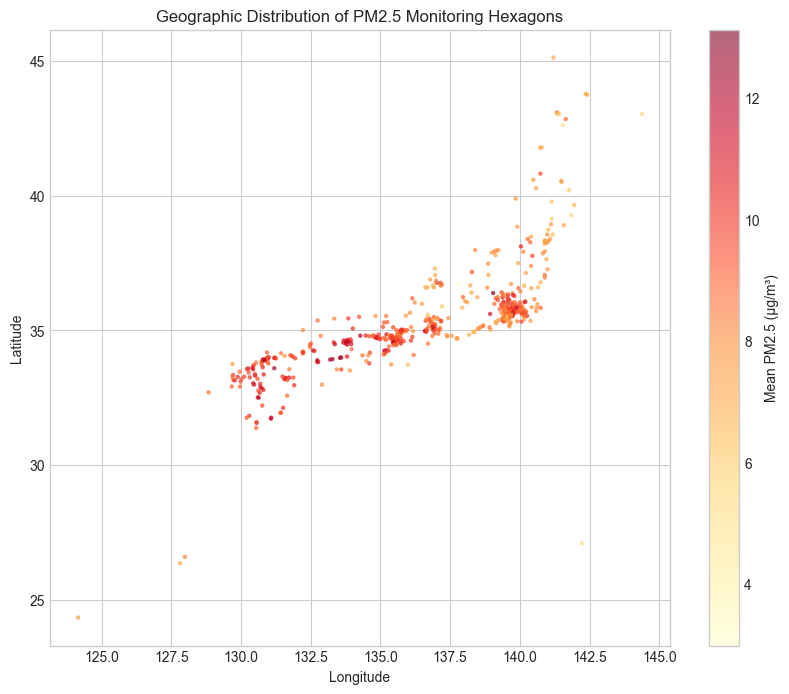

In [12]:
hex_stats = df.groupby('hex7_id').agg({
    'pm25_ugm3_mean': ['count', 'mean', 'std'],
    'lat': 'first',
    'lon': 'first'
})
hex_stats.columns = ['pm25_count', 'pm25_mean', 'pm25_std', 'lat', 'lon']

print(f"Latitude range: {hex_stats['lat'].min():.2f} to {hex_stats['lat'].max():.2f}")
print(f"Longitude range: {hex_stats['lon'].min():.2f} to {hex_stats['lon'].max():.2f}")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(hex_stats['lon'], hex_stats['lat'], 
                     c=hex_stats['pm25_mean'], cmap='YlOrRd', 
                     s=5, alpha=0.6)
plt.colorbar(scatter, label='Mean PM2.5 (μg/m³)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of PM2.5 Monitoring Hexagons')
plt.show()

### Data Completeness Summary

In [13]:
completeness = pd.DataFrame({
    'Total Records': len(df),
    'PM2.5 Available': df['pm25_ugm3_mean'].notna().sum(),
    'Traffic Data Available': df['avg_traffic_volume'].notna().sum(),
    'Weather Data Available': df['temperature_c_mean'].notna().sum(),
    'Complete Records': df[['pm25_ugm3_mean', 'avg_traffic_volume', 'temperature_c_mean']].notna().all(axis=1).sum()
}, index=['Count'])

completeness_pct = (completeness / len(df) * 100).round(1)
completeness_pct.index = ['Percentage']

print("Data Completeness:")
display(pd.concat([completeness, completeness_pct]))

Data Completeness:


,Total Records,PM2.5 Available,Traffic Data Available,Weather Data Available,Complete Records
Count,9457112.00,7617538.00,2001834.00,974342.00,751351.00
Percentage,100.00,80.50,21.20,10.30,7.90
